# A template for experiments

I'm trying to develop a pipeline we can use for experiments on the NEH data: a template we can use for selecting data, training a model, and finally evaluating results. But this is by no means set in stone yet; it's a draft we can discuss and adjust.

For a first test, let's consider the problem of author gender. We know our data model of gender is imperfect (limited for the most part to m/f), and we don't imagine a predictive model trained on this boundary will tell us very much about gender directly; it's almost certainly, to some degree, a proxy for genre. But it's a tricky boundary to model and thus a good place to start. We're in no danger of getting 100% accuracy!

Our ultimate goal in this experiment, and other experiments based on this template, is to figure out:

1. What kinds of *historical questions* are really distorted by the errors in digital libraries? Our working hypothesis is that certain boundaries (like genre and date) are likely to be more sensitive than others (like e.g. gender), because the errors are in practice not distributed randomly.

2. What kinds of *errors* are most likely to produce distortion? I'm acting on the hypothesis (or hunch) that paratext is at least as big a problem as the better-studied problem of OCR error. For instance, the paratext in works of fiction is often from a different genre, and composed at a different time, than the original work. So it's very likely to distort conclusions.

### Imports

In [1]:
import pandas as pd
import numpy as np
import os, random
from matplotlib import pyplot as plt
from scipy.stats import rankdata
from scipy.stats import pearsonr
import statsmodels.api as sm
from sklearn.model_selection import cross_validate
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import cross_val_predict
from sklearn.pipeline import Pipeline

### Volume metadata

This metadata file is in the GitHub repo. It has one row for each clean volume. 

Not all of these volumes have been trimmed and chunked; we will rely on the Box folders for a list of the chunks actually available to model. But then we will use this list in order to get features like genre, gender, and date.

In [2]:
volmeta = pd.read_csv('../metadata/updatedvolumemetadata.tsv', sep = '\t')

In [3]:
volmeta.head()

,docid,author,authordate,title,latestcomp,hathidate,imprint,gutenstring,enumcron,gbindex,...,contents,instances,genre,audience,authgender,multiplehtids,comments,coder,Folder,Trimmed
0,loc.ark+=13960=t5p851b8s,"Reid, Stuart J.",NaN,Lord John Russell,1895,NaN,New York;Harper & brothers;1,"Reid, Stuart J. | Lord John Russell",<blank>,27553,...,NaN,NaN,bio,NaN,u,NaN,NaN,morgan,gutenbiotrimmed,Trimmed
1,hvd.32044070870779,"Smiles, Samuel,",NaN,Lives of the engineers,1879,NaN,London;J. Murray;1874-1877.,"Smiles, Samuel | Lives of the Engineers",v. 5,27710,...,NaN,NaN,bio | short,NaN,m,NaN,"2 people, mixed together (not one per chapter)",morgan,gutenbiotrimmed,Trimmed
2,mdp.39015005892362,"Cruttwell, Maud.",NaN,Luca Signorelli,1899,NaN,London;G. Bell & sons;1899.,"Cruttwell, Maud | Luca Signorelli",<blank>,27759,...,NaN,NaN,bio,NaN,f,NaN,NaN,morgan,gutenbiotrimmed,Trimmed
3,mdp.39015051108531,"Bettany, George Thomas,",NaN,Life of Charles Darwin,1887,NaN,London;W. Scott;1887.,"Bettany, George Thomas | Life of Charles Darwin",<blank>,28380,...,NaN,NaN,bio,NaN,m,NaN,NaN,morgan,gutenbiotrimmed,Trimmed
4,loc.ark+=13960=t6b27z54n,"Gay, Sydney Howard,",NaN,James Madison,1889,NaN,"Boston;New York;Houghton, Mi","Gay, Sydney Howard | James Madison",<blank>,28992,...,NaN,NaN,bio,NaN,u,NaN,NaN,morgan,gutenbiotrimmed,Trimmed


Here's a function we can use to generate a simpler genre column for modeling the biography / fiction boundary.

In [4]:
def simplify_genre(genrestring):
    genres = [x.strip() for x in genrestring.split('|')]
    if 'bio' in genres:
        return 'bio'
    elif 'fic' in genres:
        return 'fic'
    else:
        print('anomaly', genrestring)
        return float('nan')

volmeta['simplegenre'] = volmeta['genre'].apply(simplify_genre)

anomaly dutch


### Works we have actually trimmed and chunked so far

The Box folders ```cleannarratives``` and ```dirtynarratives``` store processed texts.

The ```cleannarratives``` folder consists of Gutenberg texts, manually trimmed and then automatically chunked to contain ~80,000 characters each.

The ```dirtynarratives``` folder contains Hathi texts that have *not* been trimmed. The only clean-up done on these so far is that running headers have been removed. They've also been chunked to contain ~80,000 characters each, but the boundaries are not aligned with ```cleannarratives.```

Note that the number of files will not be the same in these two folders, and the number of chunks for each volume will not be the same. They are chunked independently.

In [5]:
cleanfiles = [x for x in os.listdir('/Users/tunder/Box Sync/NEHproject/cleannarratives/')
              if x.endswith('.txt')]
dirtyfiles = [x for x in os.listdir('/Users/tunder/Box Sync/NEHproject/dirtynarratives/')
               if x.endswith('.txt')]

In [6]:
print("We have " + str(len(cleanfiles)) + " clean chunks, and")
print(str(len(dirtyfiles)), " dirty ones.")

We have 2489 clean chunks, and
2610  dirty ones.


What is actually in these data objects?

In [7]:
cleanfiles[0]

'36965_3.txt'

How many *volumes* have we trimmed and chunked so far?

In [8]:
def get_gbindex(filename):
    return filename.split('_')[0]

gbdict = dict()

for filename in cleanfiles:
    gbindex = get_gbindex(filename)
    if gbindex not in gbdict:
        gbdict[gbindex] = []
    gbdict[gbindex].append(filename)

gbset = set(gbdict.keys())

In [9]:
print("We have " + str(len(gbset)) + " separate clean volumes that have been chunked.")

We have 423 separate clean volumes that have been chunked.


Let's create a dataframe with just the volumes we're actually using.

In [10]:
ourtitles = volmeta.loc[volmeta['gbindex'].isin(gbset), : ]
ourtitles.shape

(423, 25)

### Balancing the distribution of classes across time

Language change is very easy to model, so if you try to model the boundary between two categories that happen to be distributed differently across time (in your collection), you're very likely to get a model of language change. That's a problem if you want to study the categorical difference in itself, separated from confounding issues of chronology that might just be selection bias.

Here we're distinguishing books written by men from those written by women. And although we don't really care about the model in its own right (since we're interested in the consequences of OCR distortion), it's still important to know what we're modeling, because OCR distortion could have *different* effects on different kinds of boundaries (e.g. chronological or demographic). 

So we need to be careful to balance the classes across time. At a minimum, we should require the median date for both categories to be roughly the same. A more ambitious approach would match the full distribution. But for right now let's keep it simple.

Also, in order to keep things simple, let's select both classes to be the same size. So we'll match the size of the smaller class.

In [11]:
indexes_f = ourtitles.loc[ourtitles.authgender == 'f', : ].index.tolist()
indexes_m = ourtitles.loc[ourtitles.authgender == 'm', : ].index.tolist()
print('The smaller class has ', len(indexes_f), ' volumes.')

The smaller class has  139  volumes.


The following function selects a matching number of volumes while keeping the median date similar in both categories.

In [12]:
def match_medians(smaller_indexes, larger_indexes, metadata):
    '''
    smaller_indexes = indexes of metadata for the smaller class
    larger_indexes = indexes of metadata for the larger class
    '''
    selected_from_large = []
    smaller_median = np.median(metadata.loc[smaller_indexes, 'latestcomp'])
    
    largerdf = metadata.loc[larger_indexes, : ]
    above_median = largerdf.loc[largerdf['latestcomp'] >= smaller_median, : ].index.tolist()
    below_median = largerdf.loc[largerdf['latestcomp'] <= smaller_median, : ].index.tolist()
    
    for i in range(len(smaller_indexes)):
        if len(selected_from_large) > 0:
            larger_median = np.median(metadata.loc[selected_from_large, 'latestcomp'])
        else:
            larger_median = smaller_median
        
        if larger_median >= smaller_median and len(below_median) > 0:
            selected = random.sample(below_median, 1)[0]
            below_median.pop(below_median.index(selected))
            selected_from_large.append(selected)
        elif larger_median <= smaller_median and len(above_median) > 0:
            selected = random.sample(above_median, 1)[0]
            above_median.pop(above_median.index(selected))
            selected_from_large.append(selected)
        else:
            # we have no more items that won't distort the median
            break

    return selected_from_large, smaller_median, larger_median

selected_m, median_f, median_m = match_medians(indexes_f, indexes_m, ourtitles)  

In [13]:
print(median_f, median_m, len(selected_m))

1890.0 1889.0 139


In [14]:
all_selected_vols = indexes_f + selected_m
len(all_selected_vols)

278

We've gathered the actual indexes of rows in ```ourtitles.``` Now let's convert those to Gutenberg indexes (or other clean-volume identifiers, in cases where volumes are drawn from ECCO, etc.)

In [15]:
selected_gbindexes = ourtitles.loc[all_selected_vols, 'gbindex']

### Merging chunk and volume

So far we've been operating at the volume level. But we will need chunk-level metadata in order to actually model the files.

Let's create dataframes that have a row for each chunk and merge those dataframes with the information in volmeta.

In [16]:
def create_chunkframe(filelist, volmeta):
    
    chunkids = []
    gbindices = []
    
    for filename in filelist:
        chunkids.append(filename.replace('.txt', ''))
        gbindices.append(get_gbindex(filename))
    
    df = pd.DataFrame({'chunkid': chunkids, 'gbindex': gbindices})
    
    chunkmeta = df.merge(volmeta, how = 'inner', on = 'gbindex')
    
    return chunkmeta

In [17]:
cleanmeta = create_chunkframe(cleanfiles, ourtitles)
cleanmeta.shape

(2489, 26)

In [18]:
dirtymeta = create_chunkframe(dirtyfiles, ourtitles)
dirtymeta.shape

(2610, 26)

Now we select the subsets of those dataframes with Gutenberg indexes that were selected by the match_medians function.

In [19]:
cleanmodelmeta = cleanmeta.loc[cleanmeta['gbindex'].isin(selected_gbindexes), : ]
cleanmodelmeta.shape

(1560, 26)

In [20]:
dirtymodelmeta = dirtymeta.loc[dirtymeta['gbindex'].isin(selected_gbindexes), : ]
dirtymodelmeta.shape

(1648, 26)

### Term-document matrices for clean and dirty narratives 


In [21]:
clean_rootdir = '/Users/tunder/Box Sync/NEHproject/cleannarratives/'

clean_paths = []

for chunk_id in cleanmodelmeta['chunkid']:
    clean_paths.append(clean_rootdir + chunk_id + '.txt')
    

In [22]:
clean_model_chunk_ids = cleanmodelmeta['chunkid']

vectorizer = CountVectorizer(input = 'filename', min_df = .02)
sparse_clean_counts = vectorizer.fit_transform(clean_paths) # the vectorizer produces something
                                                               # called a 'sparse matrix'; we need to
                                                               # unpack it
clean_wordcounts = pd.DataFrame(sparse_clean_counts.toarray(), index = clean_model_chunk_ids, 
                            columns = vectorizer.get_feature_names())
clean_wordcounts.head()

,000,10,100,10th,11,11th,12,12th,13,13th,...,youth,youthful,youths,zeal,zealous,zealously,zenith,zest,zigzag,zone
chunkid,,,,,,,,,,,,,,,,,,,,,
36965_3,0,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
36965_2,0,2,0,0,2,0,2,1,2,0,...,0,0,0,1,0,0,0,0,0,0
36965_0,0,0,0,0,0,0,0,1,0,0,...,9,2,0,0,0,0,0,0,0,0
36965_1,0,0,0,0,0,0,0,0,0,0,...,3,1,0,0,0,0,0,0,0,0
36965_4,0,2,0,1,1,0,0,0,0,0,...,5,0,0,0,0,0,0,0,0,0


In [23]:
dirty_rootdir = '/Users/tunder/Box Sync/NEHproject/dirtynarratives/'

dirty_paths = []

for chunk_id in dirtymodelmeta['chunkid']:
    dirty_paths.append(dirty_rootdir + chunk_id + '.txt')

dirty_model_chunk_ids = dirtymodelmeta['chunkid']
    
vectorizer = CountVectorizer(input = 'filename', min_df = .02)
sparse_dirty_counts = vectorizer.fit_transform(dirty_paths) # the vectorizer produces something
                                                               # called a 'sparse matrix'; we need to
                                                               # unpack it
dirty_wordcounts = pd.DataFrame(sparse_dirty_counts.toarray(), index = dirty_model_chunk_ids, 
                            columns = vectorizer.get_feature_names())
dirty_wordcounts.head()

,00,000,01,10,100,101,102,103,104,105,...,ſwore,ſº,ﬁlled,ﬁnd,ﬁne,ﬁnished,ﬁre,ﬁrst,ﬁve,ﬁxed
chunkid,,,,,,,,,,,,,,,,,,,,,
36965_3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
36965_2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
36965_0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
36965_1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
36965_4,3,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Turn wordcounts into normalized frequencies

In [24]:
clean_rowsums = clean_wordcounts.sum(axis = 'columns')
clean_freqs = clean_wordcounts.divide(clean_rowsums, axis = 'rows')

In [25]:
dirty_rowsums = dirty_wordcounts.sum(axis = 'columns')
dirty_freqs = dirty_wordcounts.divide(dirty_rowsums, axis = 'rows')

In [26]:
dirty_freqs.head()

,00,000,01,10,100,101,102,103,104,105,...,ſwore,ſº,ﬁlled,ﬁnd,ﬁne,ﬁnished,ﬁre,ﬁrst,ﬁve,ﬁxed
chunkid,,,,,,,,,,,,,,,,,,,,,
36965_3,0.000000,0.0,0.0,0.000074,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
36965_2,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
36965_0,0.000000,0.0,0.0,0.000000,0.000073,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
36965_1,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
36965_4,0.000216,0.0,0.0,0.000072,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Notice the eighteenth-century long S's!

### Separate train & validation from final test set

We will optimize our model by cross-validating on 3/4 of the data, and finally test on a held-out 1/4. The same volumes should be held out for both clean and dirty data. Note that we select *by author* to avoid leakage across this boundary.

In [27]:
selected_authors = list(set(volmeta.loc[volmeta['gbindex'].isin(selected_gbindexes), 'author']))
random.shuffle(selected_authors)
threequarters = int(len(selected_authors) * .75)
trainauthors = selected_authors[0 : threequarters]
testauthors = selected_authors[threequarters: ]

cleantrain = cleanmodelmeta.loc[cleanmodelmeta['author'].isin(trainauthors), : ]
cleantest = cleanmodelmeta.loc[cleanmodelmeta['author'].isin(testauthors), : ]
cleantrain_freqs = clean_freqs.loc[cleantrain.chunkid]
cleantest_freqs = clean_freqs.loc[cleantest.chunkid]

dirtytrain = dirtymodelmeta.loc[dirtymodelmeta['author'].isin(trainauthors), : ]
dirtytest = dirtymodelmeta.loc[dirtymodelmeta['author'].isin(testauthors), : ]
dirtytrain_freqs = dirty_freqs.loc[dirtytrain.chunkid]
dirtytest_freqs = dirty_freqs.loc[dirtytest.chunkid]

In [28]:
print('Clean training set: ', cleantrain.shape)
print('Clean test set: ', cleantest.shape)
print('Hathi training set: ', dirtytrain.shape)
print('Hathi testing set: ', dirtytest.shape)

Clean training set:  (1231, 26)
Clean test set:  (329, 26)
Hathi training set:  (1302, 26)
Hathi testing set:  (346, 26)


Let's put our master modelmeta frames in the right order to use later.

In [29]:
dirtymodelmeta.set_index('chunkid', inplace = True)
print(dirtymodelmeta.shape)
dirty_ids_order = np.append(list(dirtytrain.chunkid), list(dirtytest.chunkid))
dirtymodelmeta = dirtymodelmeta.loc[dirty_ids_order, : ]
dirtymodelmeta.reset_index(inplace = True)
dirtymodelmeta.shape

(1648, 25)


(1648, 26)

In [30]:
cleanmodelmeta.set_index('chunkid', inplace = True)
print(cleanmodelmeta.shape)
clean_ids_order = np.append(list(cleantrain.chunkid), list(cleantest.chunkid))
cleanmodelmeta = cleanmodelmeta.loc[clean_ids_order, : ]
cleanmodelmeta.reset_index(inplace = True)
cleanmodelmeta.shape

(1560, 25)


(1560, 26)

### Let's produce a model for the clean counts

We're going to do a grid search for the best model. The outer loop will select the number of features. The inner loop will select the regularization constant.

In selecting the top *n* features, we will always select the *n* with top *document* frequency.

We will do the cross-validation only on the training set. This means in effect that there are lots of different "validation sets" inside the training set. But the test set itself is a separate issue.

In [31]:
def get_doc_freqs(X, y):
    return np.count_nonzero(X, axis=0)
        

In [45]:
resultarray = []

featureoptions = [1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000, 5500, 6000, 7000]
c_options = [10000, 3000, 1000, 500, 100, 10, 1, .1, .01, .001, .0001]

for featurecount in featureoptions:
    docfreqs = []
    for col in cleantrain_freqs.columns:
        docfreqs.append((sum(cleantrain_freqs[col] > 0), col))
    docfreqs.sort()
    features = [x[1] for x in docfreqs[-featurecount : ]] # because sorted in ascending order
    
    model_features = cleantrain_freqs.loc[ : , features]
    
    resultrow = []
    
    for c_param in c_options:
        logreg = LogisticRegression(C = c_param, max_iter = 2000)
        scaler = StandardScaler()
        # feature_selector = SelectKBest(get_doc_freqs, k = featurecount)
        pipe = Pipeline([
            # ('fkb', feature_selector),
            ('sc', scaler),
            ('lr', logreg)
        ])    
        grouper = GroupKFold(n_splits = 10)
        cv_results = cross_validate(estimator = pipe, 
                                    X = model_features,
                                    y = cleantrain['authgender'], 
                                    groups = cleantrain['author'], 
                                    cv = grouper)
        mean_score = np.mean(cv_results['test_score'])
        print(featurecount, c_param, mean_score)
        resultrow.append(mean_score)
    
    resultarray.append(resultrow)
     

1000 10000 0.7148177288224495
1000 3000 0.7123787044322057
1000 1000 0.7042486231313927
1000 500 0.7034356150013114
1000 100 0.7058746393915553
1000 10 0.7091332284290586
1000 1 0.7099396800419616
1000 0.1 0.7156241804353527
1000 0.01 0.7391883031733543
1000 0.001 0.7473183844741673
1000 0.0001 0.7051075268817205
1500 10000 0.7278455284552845
1500 3000 0.728658536585366
1500 1000 0.7270325203252033
1500 500 0.7254130605822187
1500 100 0.7254130605822188
1500 10 0.7270325203252033
1500 1 0.7327235772357723
1500 0.1 0.7367886178861789
1500 0.01 0.7465184893784422
1500 0.001 0.7570679255179649
1500 0.0001 0.7213414634146342
2000 10000 0.7148373983739837
2000 3000 0.7172698662470495
2000 1000 0.7132179386309991
2000 500 0.7115984788880148
2000 100 0.7116050354051928
2000 10 0.7148439548911617
2000 1 0.7189024390243903
2000 0.1 0.7294584316810909
2000 0.01 0.7383884080776292
2000 0.001 0.7578743771308682
2000 0.0001 0.7237608182533439
2500 10000 0.7238001573564122
2500 3000 0.72865198006818

#### visualize the grid search

This can be a good way to check that you've really covered the space and "surrounded" the optimum value on all sides.

In [46]:
resultarray = np.array(resultarray)
thearrayshape = resultarray.shape
resarray = rankdata(resultarray).reshape(thearrayshape)   # I'm doing this because otherwise
                                                    # fine details at top of range can be hard to see.

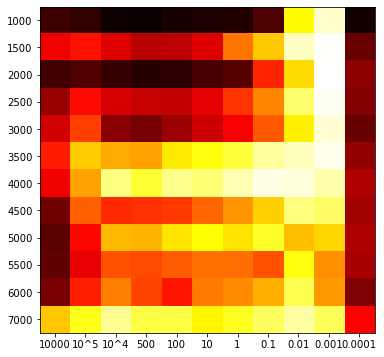

In [47]:
fig, ax = plt.subplots(figsize=(6,6))

ax.imshow(resarray, cmap='hot', aspect = 'auto')
plt.yticks(ticks = [x for x in range(len(featureoptions))], labels = featureoptions)
thexlabels = [str(x) for x in c_options]
thexlabels[0] = '10^4'
plt.xticks(ticks = [x for x in range(len(c_options))], labels = thexlabels)
plt.show()

In [48]:
maxtuple = np.where(resarray == np.amax(resarray))
print(featureoptions[maxtuple[0][0]], c_options[maxtuple[1][0]])

2000 0.001


In [49]:
docfreqs = []
for col in clean_wordcounts.columns:
    docfreqs.append((sum(clean_wordcounts[col] > 0), col))
docfreqs.sort()
features = [x[1] for x in docfreqs[-2000: ]] #because sorted ascending

train_features = cleantrain_freqs.loc[ : , features]  
    
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)

bestmodel = LogisticRegression(C = .001, max_iter = 2000)
cleantrain_probabilities = cross_val_predict(bestmodel, train_features, cleantrain['authgender'], 
                                     groups = cleantrain['author'], cv = grouper,
                                    method = 'predict_proba')

## NOW APPLY THE SAME SCALER AND MODEL TO TEST SET

bestmodel = LogisticRegression(C = .001, max_iter = 2000)
bestmodel.fit(train_features, cleantrain['authgender'])

test_features = cleantest_freqs.loc[ : , features] 
test_features = scaler.transform(test_features) # Note this is the same scaler we fit
                                                # to train features; we DON'T fit a new one to the
                                                # test features. We deliberately blind ourselves to that
                                                # information.

cleantest_predictions = bestmodel.predict(test_features)
cleantest_probabilities = bestmodel.predict_proba(test_features)


In [50]:
sum(cleantest_predictions == cleantest['authgender']) / len(cleantest['authgender'])

0.8145896656534954

### Now a model for the dirty counts

In [54]:
resultarray = []

featureoptions = [1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000, 5500, 6000, 6500, 7000]
c_options = [100000, 10000, 3000, 1000, 500, 100, 10, 1, .1, .01, .001, .0001]

for featurecount in featureoptions:
    docfreqs = []
    for col in dirtytrain_freqs.columns:
        docfreqs.append((sum(dirtytrain_freqs[col] > 0), col))
    docfreqs.sort()
    features = [x[1] for x in docfreqs[-featurecount: ]]  # because sorted ascending
    
    model_features = dirtytrain_freqs.loc[ : , features]
    
    resultrow = []
    
    for c_param in c_options:
        logreg = LogisticRegression(C = c_param, max_iter = 2000)
        scaler = StandardScaler()
        # feature_selector = SelectKBest(get_doc_freqs, k = featurecount)
        pipe = Pipeline([
            # ('fs', feature_selector),
            ('sc', scaler),
            ('lr', logreg)
        ])
        grouper = GroupKFold(n_splits = 10)
        cv_results = cross_validate(estimator = pipe, 
                                    X = model_features, 
                                    y = dirtytrain['authgender'], 
                                    groups = dirtytrain['author'], 
                                    cv = grouper)
        mean_score = np.mean(cv_results['test_score'])
        print(featurecount, c_param, mean_score)
        resultrow.append(mean_score)
    
    resultarray.append(resultrow)
    

1000 100000 0.6864322877548513
1000 10000 0.6955866300691438
1000 3000 0.6993739729706355
1000 1000 0.703202601883589
1000 500 0.7016700123357322
1000 100 0.7001314597586568
1000 10 0.6970720616149341
1000 1 0.7001430216626383
1000 0.1 0.7039479805359444
1000 0.01 0.7070370117485332
1000 0.001 0.7147413365378925
1000 0.0001 0.6708931798422301
1500 100000 0.6948711576014966
1500 10000 0.701019222803352
1500 3000 0.7017292784734644
1500 1000 0.7048123466568346
1500 500 0.7063449362046913
1500 100 0.7071083860219313
1500 10 0.7124694224055134
1500 1 0.711682484625854
1500 0.1 0.7170790260689072
1500 0.01 0.7309137090496934
1500 0.001 0.733937511095331
1500 0.0001 0.6839584499765575
2000 100000 0.7125580484962697
2000 10000 0.7248661049584182
2000 3000 0.7294520385821647
2000 1000 0.730203562340967
2000 500 0.7286650097638915
2000 100 0.7317420238794285
2000 10 0.7301975993117481
2000 1 0.7363456645136035
2000 0.1 0.7401920004369854
2000 0.01 0.7409614132834441
2000 0.001 0.734748300991865

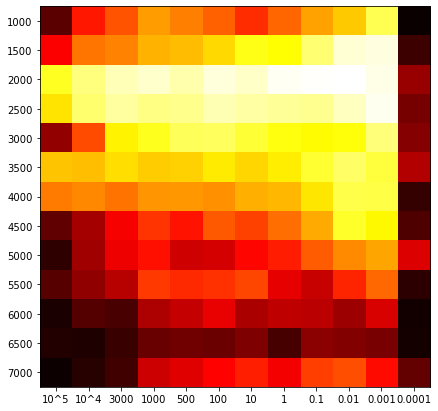

In [55]:
resultarray = np.array(resultarray)
thearrayshape = resultarray.shape
resarray = rankdata(resultarray).reshape(thearrayshape)   # I'm doing this because otherwise
                                                    # fine details at top of range can be hard to see.
fig, ax = plt.subplots(figsize=(7,7))

ax.imshow(resarray, cmap='hot', aspect = 'auto')
plt.yticks(ticks = [x for x in range(len(featureoptions))], labels = featureoptions)
thexlabels = [str(x) for x in c_options]
thexlabels[0] = '10^5'
thexlabels[1] = '10^4'
plt.xticks(ticks = [x for x in range(len(c_options))], labels = thexlabels)
plt.show()

In [56]:
maxtuple = np.where(resarray == np.amax(resarray))
print(featureoptions[maxtuple[0][0]], c_options[maxtuple[1][0]])

2000 0.01


In [57]:
docfreqs = []
for col in dirtytrain_freqs.columns:
    docfreqs.append((sum(dirtytrain_freqs[col] > 0), col))
docfreqs.sort()
features = [x[1] for x in docfreqs[-2000 : ]]

train_features = dirtytrain_freqs.loc[ : , features]
    
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)

bestmodel = LogisticRegression(C = .01, max_iter = 2000)
dirtytrain_probabilities = cross_val_predict(bestmodel, train_features, dirtytrain['authgender'], 
                                     groups = dirtytrain['author'], cv = grouper,
                                    method = 'predict_proba')

## NOW APPLY THE SAME SCALER AND MODEL TO TEST SET

bestmodel = LogisticRegression(C = .01, max_iter = 2000)
bestmodel.fit(train_features, dirtytrain['authgender'])

test_features = dirtytest_freqs.loc[ : , features] 
test_features = scaler.transform(test_features)    # Note this is the same scaler we fit
                                                # to train features; we DON'T fit a new one to the
                                                # test features. We deliberately blind ourselves to that
                                                # information.

dirtytest_predictions = bestmodel.predict(test_features)
dirtytest_probabilities = bestmodel.predict_proba(test_features)

In [58]:
sum(dirtytest_predictions == dirtytest['authgender']) / len(dirtytest['authgender'])

0.815028901734104

So, looking both at the cross-validation and at the held-out test set, it appears that we get *slightly* worse accuracy with dirty data.

### The actual fun stuff: what creates the error?

I've saved the prediction probabilities from cross-validation on the training set (and from prediction on test), so that we can measure error for each chunk and try to diagnose the sources of error.

Our strategy here involves three measurements.

1. The "divergence from clean": how much does prediction error on a dirty chunk exceed (or fall below) the average error for clean chunks of this volume. Note that we cannot create a chunk-to-chunk mapping, since Hathi has not been trimmed.

2. The "worderrors" for the chunk: how many words in the Hathi chunk were not found *either* in the Gutenberg text or in a simple dictionary of 10,000 common English words? This is not exactly the same as word-error-rate, but it's a close approximation that we can use for the moment.

3. The "passagefails" for the chunk. What fraction of 20-character segments in the Hathi chunk could be found with fuzzy matching in (the whole) Gutenberg volume. We accepted difflib similarity scores of > 0.78 as a a match. This is **in effect** a measurement of the amount of text in the chunk that is substantially *different from* the Gutenberg text, because it's a table of contents, or introduction, or notes -- or a different translation!

The question we're trying to answer: does accuracy fall mostly because of OCR errors, or because of paratext? As you'll see, it's difficult to answer with these corpora. This evidence casts some light, but we will also need more experiments with multiple corpora.

We start by constructing vectors for real y and predicted $\widehat{y}$ — for both models.

In [59]:
dirty_y = dirtymodelmeta['authgender'].map({'f': 1, 'm': 0})  # we already put this in train-test order
                                                            # so it will match the next line
dirty_probabilities = np.append(dirtytrain_probabilities[ : , 0], dirtytest_probabilities[ : , 0])

We can reason about two kinds of error. 

Directional error: did this chunk appear more negative or positive than it was in the real y vector.

Absolute error: how far was this chunk from the real value in either direction.

In [60]:
dirty_error = dirty_y - dirty_probabilities
dirty_absolute_error = np.abs(dirty_error)

Repeat the above steps for the clean model.

In [61]:
clean_y = cleanmodelmeta['authgender'].map({'f': 1, 'm': 0})

clean_probabilities = np.append(cleantrain_probabilities[ : , 0], cleantest_probabilities[ : , 0])

In [62]:
clean_error = clean_y - clean_probabilities
clean_absolute_error = np.abs(clean_error)

#### Create mean values for clean volumes

We create a dataframe and then groupby / average on Gutenberg indexes.

In [63]:
clean_gbi = [get_gbindex(x) for x in cleanmodelmeta['chunkid']]
clean_df = pd.DataFrame({'chunkid': cleanmodelmeta['chunkid'], 'gbindex': clean_gbi,
                         'clean_error': clean_error, 'clean_abs_error': clean_absolute_error})

In [64]:
meandf = clean_df.groupby('gbindex').mean()

In [65]:
meandf.sample(10)

,clean_error,clean_abs_error
gbindex,,
48795,-0.380096,0.380096
35557,0.518421,0.518421
57149,0.368115,0.368115
37908,0.217119,0.217119
3841,0.417768,0.417768
RichSPO3fic,-0.381683,0.381683
37361,-0.413712,0.413712
28694,-0.108656,0.108656
35500,-0.213543,0.213543


In [66]:
dirty_gbi = [get_gbindex(x) for x in dirtymodelmeta['chunkid']]
dirty_df = pd.DataFrame({'chunkid': list(dirtymodelmeta['chunkid']), 'gbindex': dirty_gbi,
                         'dirty_error': dirty_error, 'dirty_abs_error': dirty_absolute_error})

In [67]:
dirty_df.sample(5)

,chunkid,gbindex,dirty_error,dirty_abs_error
459,6593_26,6593,-0.253745,0.253745
623,696_2,696,-0.800630,0.800630
234,51932_3,51932,0.150403,0.150403
1302,44262_8,44262,0.167118,0.167118
1353,37710_1,37710,0.157606,0.157606


In [68]:
dirty_df = dirty_df.merge(meandf, on = 'gbindex')
dirty_df['error_divergence'] = dirty_df['dirty_error'] - dirty_df['clean_error']
dirty_df['divergence_of_abs_error'] = dirty_df['dirty_abs_error'] - dirty_df['clean_abs_error']
dirty_df.sample(10)

,chunkid,gbindex,dirty_error,dirty_abs_error,clean_error,clean_abs_error,error_divergence,divergence_of_abs_error
68,6098_2,6098,-0.714614,0.714614,-0.605641,0.605641,-0.108973,0.108973
762,63339_2,63339,0.725906,0.725906,0.403260,0.403260,0.322646,0.322646
1147,manley.01_5,manley.01,0.087757,0.087757,0.209378,0.209378,-0.121621,-0.121621
976,2512_0,2512,-0.019852,0.019852,-0.094151,0.094151,0.074299,-0.074299
1282,LewiMMR2fic_3,LewiMMR2fic,-0.902269,0.902269,-0.644809,0.644809,-0.257460,0.257460
1361,33537_5,33537,0.131193,0.131193,0.292917,0.292917,-0.161724,-0.161724
1545,55594_6,55594,0.081366,0.081366,0.498117,0.498117,-0.416751,-0.416751
1072,52019_4,52019,0.019685,0.019685,0.147768,0.147768,-0.128084,-0.128084
1514,34476_3,34476,-0.417151,0.417151,-0.277048,0.277048,-0.140103,0.140103
292,35548_4,35548,0.030277,0.030277,0.222919,0.222919,-0.192642,-0.192642


In [69]:
error0 = pd.read_csv('/Users/tunder/work/gh_align/hathinocorrerrs0.tsv', sep = '\t')
error1 = pd.read_csv('/Users/tunder/work/gh_align/hathinocorrerrs1.tsv', sep = '\t')
error2 = pd.read_csv('/Users/tunder/work/gh_align/hathinocorrerrs2.tsv', sep = '\t')
error3 = pd.read_csv('/Users/tunder/work/gh_align/hathinocorrerrs3.tsv', sep = '\t')
error4 = pd.read_csv('/Users/tunder/work/gh_align/hathinocorrerrs4.tsv', sep = '\t')
#error5 = pd.read_csv('/Users/tunder/work/gh_align/hathichunkerrs5.tsv', sep = '\t')
chunkerrors = pd.concat([error0, error1, error2, error3, error4], ignore_index = True)

In [339]:
#chunkerrors.drop_duplicates(inplace = True)
#print(chunkerrors.shape)
#chunkerrors.to_csv('../metadata/hathi_chunk_errors.tsv', sep = '\t', index = False)
#chunkerrors = pd.read_csv('../metadata/hathi_chunk_errors.tsv', sep = '\t')

In [383]:
chunkerrors.columns

Index(['chunkid', 'passagefails', 'worderrors'], dtype='object')

In [70]:
chunkerrors = chunkerrors.merge(dirty_df, on = 'chunkid', how = 'left')
chunkerrors.shape

(2624, 10)

In [71]:
chunkerrors.dropna(inplace=True)
chunkerrors.shape

(1648, 10)

In [72]:
pearsonr(chunkerrors['error_divergence'], chunkerrors['divergence_of_abs_error'])

(-0.04157113940721571, 0.09159321190666851)

In [74]:
pearsonr(chunkerrors['passagefails'], chunkerrors['error_divergence'])

(0.10461367641032888, 2.0875993389670293e-05)

In [75]:
pearsonr(chunkerrors['passagefails'], chunkerrors['divergence_of_abs_error'])

(0.04886063436452093, 0.04734457556816991)

In [76]:
pearsonr(chunkerrors['worderrors'], chunkerrors['error_divergence'])

(-0.08972116516622668, 0.0002654491810300403)

In [77]:
pearsonr(chunkerrors['worderrors'], chunkerrors['divergence_of_abs_error'])

(0.0006329139431856881, 0.9795173562008995)

The sheer amount of error correlates *barely,* and *very weakly* with paratext. It has no relation to OCR error.

The *direction* of change (```error_divergence```) has a significant relation to both OCR and paratext. Paratext makes the model more likely to interpret a text as written by a woman; OCR error makes it more likely to attribute it to a man.

But all of these relationships are fairly weak.

We can also reason about the absolute value of the difference between clean and dirty. In other words, we could decide not to care whether error was increased or decreased, or which direction the prediction moved, and instead care only about how *different* the prediction is. Here only paratext matters.

In [84]:
pearsonr(chunkerrors['passagefails'], np.abs(chunkerrors['error_divergence']))

(0.10027685258057445, 4.5426894304919116e-05)

In [79]:
pearsonr(chunkerrors['worderrors'], np.abs(chunkerrors['error_divergence']))

(0.010698034598122123, 0.66430611153246)

That won't change if we substitute ```divergence_of_abs_error```.

Finally, we want to think about the correlation of our predictors.

In [80]:
pearsonr(chunkerrors['passagefails'], chunkerrors['worderrors'])

(0.06263192647539553, 0.010985920807017623)

**NOTE**: That's not a high correlation. There's not a huge danger of collinearity now.

## Interpretation

In [81]:
y = chunkerrors['divergence_of_abs_error']
X = sm.add_constant(chunkerrors.loc[ : , ['passagefails', 'worderrors']])

model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                               OLS Regression Results                              
Dep. Variable:     divergence_of_abs_error   R-squared:                       0.002
Model:                                 OLS   Adj. R-squared:                  0.001
Method:                      Least Squares   F-statistic:                     1.973
Date:                     Thu, 29 Apr 2021   Prob (F-statistic):              0.139
Time:                             08:11:37   Log-Likelihood:                 359.26
No. Observations:                     1648   AIC:                            -712.5
Df Residuals:                         1645   BIC:                            -696.3
Df Model:                                2                                         
Covariance Type:                 nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------

So, in short, when we consider both the gross inclusion of text that's not in Gutenberg (```passagefails```) and OCR quality, as measured by spelling errors in individual words (```worderrors```), only the former appears to be significantly distorting for the absolute amount of error.

When we consider change directionally, they're both significantly associated (but are presumably to some extent cancelling each other out). Note that we've established ```passagefails``` and ```worderrors``` aren't significantly associated at the chunk level, but they might still be associated at the level of volumes.

In [82]:
y = chunkerrors['error_divergence']
X = sm.add_constant(chunkerrors.loc[ : , ['passagefails', 'worderrors']])

model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:       error_divergence   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     17.00
Date:                Thu, 29 Apr 2021   Prob (F-statistic):           4.93e-08
Time:                        08:11:50   Log-Likelihood:                 319.01
No. Observations:                1648   AIC:                            -632.0
Df Residuals:                    1645   BIC:                            -615.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0069      0.006      1.138   

For this problem (gender prediction), none of the effects are really huge. Practically speaking, for downstream conclusions, none of the errors are a big thing to worry about. That may not hold equally true for genre and date prediction.